In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

from auxiliary import plot_cm, plot_nn_loss, plot_nn_metrics, plot_roc, save_metrics, drop_var_nonobj, drop_var_obj

import os
import tempfile

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
#Change path according to directory used
df = pd.read_csv(r'C:\Users\henri\OneDrive\Documentos\EDSA\EDS Bootcamp\Project\Data\HR_DS.csv')

In [3]:
# Remove non object variables with no variability
drop_var_nonobj(df)

2 columns, ['EmployeeCount', 'StandardHours'] were droped


In [4]:
# Remove object variables with no variability
drop_var_obj(df)

The ['Over18'] column was droped.


In [5]:
objects = df.describe(include='O').columns.tolist()
non_objs = df.describe().columns.tolist()

patterns = [' ', 'Travel_', '-', '&']

for p in patterns:
    df[objects] = df[objects].apply(lambda x: x.str.replace(p, ''))
    print('Pattern "{}" cleared.'.format(p))

Pattern " " cleared.
Pattern "Travel_" cleared.
Pattern "-" cleared.
Pattern "&" cleared.


In [6]:
minmax = MinMaxScaler()
df_pre_ss = pd.concat([df[objects], pd.DataFrame(minmax.fit_transform(df[non_objs]), columns=df[non_objs].columns)], axis=1, sort=False)

Making some dummies

In [7]:
finaldf = pd.get_dummies(df_pre_ss, drop_first=True)

# Models Initial Testing (Train, Val, Test)
First, the dataset has to be split into 3 sets of data so that the following is available for every model:
* A train dataset (features and labels appart) (80%)
* A validation dataset (features and labels appart) (10%)
    * Will be used to validate the train dataset
* A test dataset (features and labels appart) (10%)
    * Will be used to test the final models as an out of sample dataset.

In [8]:
# test 10%; val 10%; train 80%
train_df, test_df = train_test_split(finaldf, test_size=0.1, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=123)

# Form np arrays of labels and features
train_labels = np.array(train_df.pop('Attrition_Yes'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Attrition_Yes'))
test_labels = np.array(test_df.pop('Attrition_Yes'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)
print('')
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (1190,)
Validation labels shape: (133,)
Test labels shape: (147,)

Training features shape: (1190, 45)
Validation features shape: (133, 45)
Test features shape: (147, 45)


A check on the imbalance of the datasets is needed

In [9]:
neg, pos = np.bincount(finaldf.Attrition_Yes)
total = neg + pos
print('Cases on full dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on full dataset:
    Total: 1470
    Employees that Left the company: 237 (16.12% of total)



In [10]:
neg, pos = np.bincount(test_labels)
total = neg + pos
print('Cases on test dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on test dataset:
    Total: 147
    Employees that Left the company: 17 (11.56% of total)



In [11]:
neg, pos = np.bincount(val_labels)
total = neg + pos
print('Cases on validation dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on validation dataset:
    Total: 133
    Employees that Left the company: 23 (17.29% of total)



In [12]:
neg, pos = np.bincount(train_labels)
total = neg + pos
print('Cases on training dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on training dataset:
    Total: 1190
    Employees that Left the company: 197 (16.55% of total)



A determination of the weights of the target label will be important further on the testing of the models

In [13]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2
weight_for_1 = (1 / pos)*(total)/2

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (Stayers): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Leavers): {:.2f}'.format(weight_for_1))

Weight for class 0 (Stayers): 0.60
Weight for class 1 (Leavers): 3.02


In [14]:
# initialization of the dataframe to store the metrics for each model evaluated on test split
models_summary = pd.DataFrame(columns=['model','tp', 'fp', 'tn', 'fn', 
                                       'acc', 'prec', 'recall', 'auc', 'f1', 'mc_coef', 
                                       'batch_s'])

## 1. Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression as LR

Gridsearch:

In [88]:
m_log = LR(class_weight=class_weights,
                     random_state=0,
                     multi_class='ovr',
                     n_jobs=6)

parameters = [{'solver' : ['sag'],
              'C' : [1, 10, 100],
              'max_iter': [10000],
              'penalty' : ('none', 'l2'),
              'warm_start' : (True, False),
              'fit_intercept' : [True, False]},
              {'solver' : ['liblinear', 'saga'], 
              'C' : [1, 10, 100],
              'max_iter': [10000],
              'penalty' : ('l1', 'l2'),
              'warm_start' : (True, False),
              'fit_intercept' : [True, False]}]
grid_s = sklearn.model_selection.GridSearchCV(m_log, parameters, cv=10, refit=True, n_jobs=6, verbose=1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_logistic = grid_s.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.9s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   12.6s


LogisticRegression(C=1,
                   class_weight={0: 0.5991943605236657, 1: 3.0203045685279184},
                   dual=False, fit_intercept=False, intercept_scaling=1,
                   l1_ratio=None, max_iter=10000, multi_class='ovr', n_jobs=6,
                   penalty='l2', random_state=0, solver='sag', tol=0.0001,
                   verbose=0, warm_start=True)


[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed:   30.0s finished


In [89]:
models_summary = save_metrics(models_summary, model_logistic, test_labels, model_logistic.decision_function(test_features)>0.5)
models_summary.sort_values(by=['f1', 'auc', 'prec'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
5,NN_base,11,5,125,6,0.925170,0.687500,0.647059,0.804299,0.666667,0.624929,64.0
1,"LinearSVC(C=3, class_weight={0: 0.599194360523...",10,5,125,7,0.918367,0.666667,0.588235,0.774887,0.625000,0.580828,NaN
0,"LogisticRegression(C=1,\n cl...",13,15,115,4,0.870748,0.464286,0.764706,0.824661,0.577778,0.528814,NaN
8,"LogisticRegression(C=1,\n cl...",13,15,115,4,0.870748,0.464286,0.764706,0.824661,0.577778,0.528814,NaN
6,NN_weighted,15,22,108,2,0.836735,0.405405,0.882353,0.856561,0.555556,0.525488,64.0
4,"(DecisionTreeClassifier(class_weight=None, cri...",8,4,126,9,0.911565,0.666667,0.470588,0.719910,0.551724,0.513704,NaN
7,NN_resampled,12,15,115,5,0.863946,0.444444,0.705882,0.795249,0.545455,0.487688,64.0
3,"RadiusNeighborsClassifier(algorithm='auto', le...",1,0,130,16,0.891156,1.000000,0.058824,0.529412,0.111111,0.228860,NaN
2,"SVC(C=3, cache_size=200,\n class_weight={0:...",0,0,130,17,0.884354,0.000000,0.000000,0.500000,0.000000,0.000000,NaN


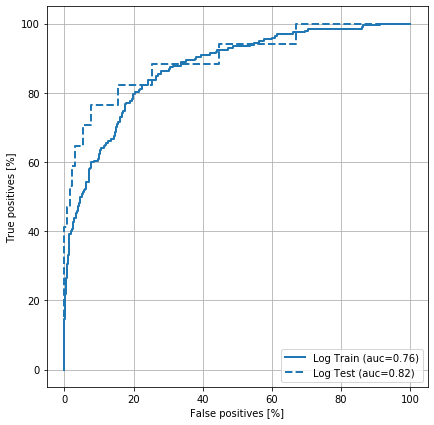

Stayers Detected (True Negatives):  88
Leavers Incorrectly Detected (False Positives):  22
Stayers Incorrectly Detected (False Negatives):  5
Leavers Detected (True Positives):  18


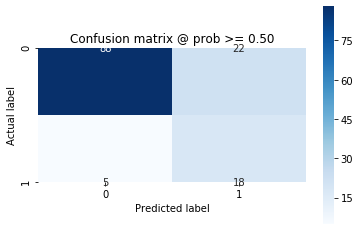

In [18]:
plt.figure(figsize=(7, 7))
plot_roc("Log Train", train_labels, model_logistic.decision_function(train_features), lcolor=colors[0])
plot_roc("Log Test", test_labels, model_logistic.decision_function(test_features), lcolor=colors[0], lstyle='--')
plt.legend(loc='lower right')
plt.show()
plot_cm(val_labels, model_logistic.predict(val_features))

## 2. LinearSVC

In [19]:
from sklearn.svm import LinearSVC as LSVC

GridSearch:

In [20]:
m_LinearSVC = LSVC(dual=False,
                   loss = 'squared_hinge',
                   tol=0.0001, 
                   multi_class='ovr', 
                   fit_intercept=True, 
                   intercept_scaling=1, 
                   class_weight=class_weights, 
                   random_state=0)

parameters = [{'C' : [i for i in range(1,10,2)],
               'penalty' : ['l1', 'l2'],
               'max_iter': [10000, 100000, 1000000]}]

grid_s = sklearn.model_selection.GridSearchCV(m_LinearSVC, parameters, cv=10, refit=True, n_jobs=-1, verbose=1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_LinearSVC = grid_s.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.0s finished


LinearSVC(C=3, class_weight={0: 0.5991943605236657, 1: 3.0203045685279184},
          dual=False, fit_intercept=True, intercept_scaling=1,
          loss='squared_hinge', max_iter=10000, multi_class='ovr', penalty='l1',
          random_state=0, tol=0.0001, verbose=0)


In [21]:
models_summary = save_metrics(models_summary, model_LinearSVC, test_labels, model_LinearSVC.decision_function(test_features)>0.5)
models_summary.sort_values(by=['f1', 'auc', 'prec'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
1,"LinearSVC(C=3, class_weight={0: 0.599194360523...",10,5,125,7,0.918367,0.666667,0.588235,0.774887,0.625000,0.580828,NaN
0,"LogisticRegression(C=1,\n cl...",13,15,115,4,0.870748,0.464286,0.764706,0.824661,0.577778,0.528814,NaN


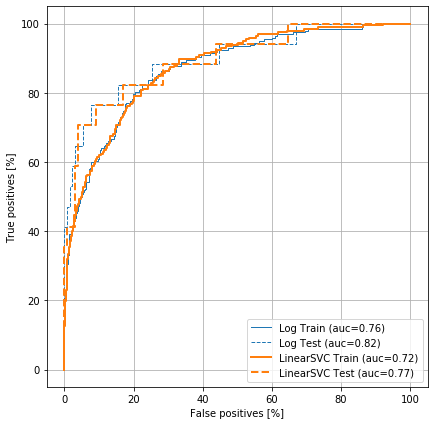

Stayers Detected (True Negatives):  100
Leavers Incorrectly Detected (False Positives):  30
Stayers Incorrectly Detected (False Negatives):  3
Leavers Detected (True Positives):  14


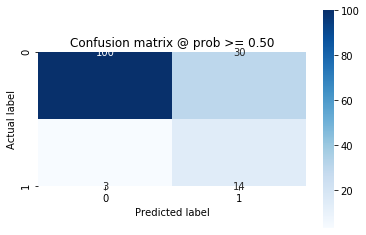

In [22]:
plt.figure(figsize=(7, 7))
plot_roc("Log Train", train_labels, model_logistic.decision_function(train_features), lcolor=colors[0], lwidth=1)
plot_roc("Log Test", test_labels, model_logistic.decision_function(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[1])
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[1], lstyle='--')
plt.legend(loc='lower right')
plt.show()

plot_cm(test_labels, model_LinearSVC.predict(test_features))

## 3. SVC

In [23]:
from sklearn.svm import SVC

In [24]:
m_SVC = SVC(probability=True, 
            tol=0.001, 
            cache_size=200,
            decision_function_shape='ovr',
            class_weight=class_weights,
            random_state=0,
            max_iter=5000)

parameters = [{'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'],
               'C' : [i for i in range(1,10,2)],
               'gamma' : [1, 0.1],
               'coef0' : [1, 0.1],
               'shrinking' : [True, False]}]

grid_s = sklearn.model_selection.GridSearchCV(m_SVC, parameters, cv=10, refit=True, n_jobs=-1, verbose=1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_SVC = grid_s.best_estimator_

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=3, cache_size=200,
    class_weight={0: 0.5991943605236657, 1: 3.0203045685279184}, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


In [25]:
models_summary = save_metrics(models_summary, model_SVC, test_labels, model_SVC.decision_function(test_features)>0.5)
models_summary.sort_values(by=['f1', 'auc', 'prec'], ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
1,"LinearSVC(C=3, class_weight={0: 0.599194360523...",10,5,125,7,0.918367,0.666667,0.588235,0.774887,0.625000,0.580828,NaN
0,"LogisticRegression(C=1,\n cl...",13,15,115,4,0.870748,0.464286,0.764706,0.824661,0.577778,0.528814,NaN
2,"SVC(C=3, cache_size=200,\n class_weight={0:...",0,0,130,17,0.884354,0.000000,0.000000,0.500000,0.000000,0.000000,NaN


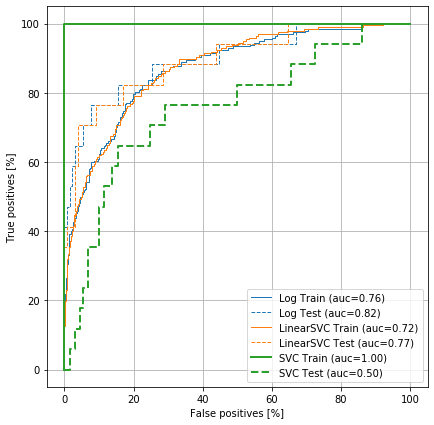

Stayers Detected (True Negatives):  130
Leavers Incorrectly Detected (False Positives):  0
Stayers Incorrectly Detected (False Negatives):  17
Leavers Detected (True Positives):  0


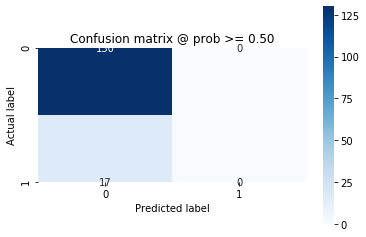

In [26]:
plt.figure(figsize=(7, 7))
plot_roc("Log Train", train_labels, model_logistic.decision_function(train_features), lcolor=colors[0], lwidth=1)
plot_roc("Log Test", test_labels, model_logistic.decision_function(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[1], lwidth=1)
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("SVC Train", train_labels, model_SVC.decision_function(train_features), lcolor=colors[2])
plot_roc("SVC Test", test_labels, model_SVC.decision_function(test_features), lcolor=colors[2], lstyle='--')
plt.legend(loc='lower right')
plt.show()

plot_cm(test_labels, model_SVC.predict(test_features))

## 4. Radius Neighbors Classifier

In [27]:
from sklearn.neighbors import RadiusNeighborsClassifier as RadiusNC

In [28]:
m_RadiusNC = RadiusNC(algorithm='auto',
                      n_jobs=-1)

parameters = [{'radius' : [i for i in range(10, 30, 2)],
               'leaf_size' : [i for i in range(5, 40, 5)],
               'weights' : ['uniform', 'distance'],
               'p' : [1, 2, 3]}]

grid_s = sklearn.model_selection.GridSearchCV(m_RadiusNC, parameters, cv=10, refit=True, n_jobs=-1, verbose=1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_RadiusNC = grid_s.best_estimator_

Fitting 10 folds for each of 420 candidates, totalling 4200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:   53.9s


RadiusNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                          metric_params=None, n_jobs=-1, outlier_label=None,
                          p=1, radius=10, weights='distance')


[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed:   57.0s finished


In [29]:
models_summary = save_metrics(models_summary, model_RadiusNC, test_labels, model_RadiusNC.predict(test_features))
models_summary.sort_values(by=['f1', 'auc', 'prec'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
1,"LinearSVC(C=3, class_weight={0: 0.599194360523...",10,5,125,7,0.918367,0.666667,0.588235,0.774887,0.625000,0.580828,NaN
0,"LogisticRegression(C=1,\n cl...",13,15,115,4,0.870748,0.464286,0.764706,0.824661,0.577778,0.528814,NaN
3,"RadiusNeighborsClassifier(algorithm='auto', le...",1,0,130,16,0.891156,1.000000,0.058824,0.529412,0.111111,0.228860,NaN
2,"SVC(C=3, cache_size=200,\n class_weight={0:...",0,0,130,17,0.884354,0.000000,0.000000,0.500000,0.000000,0.000000,NaN


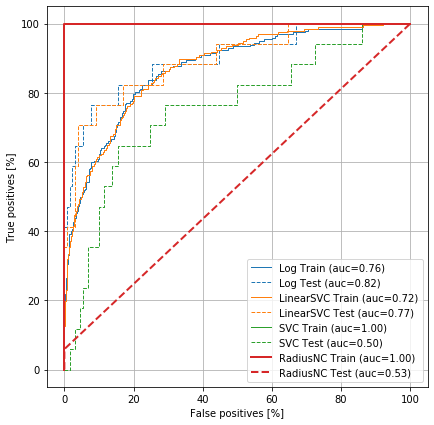

Stayers Detected (True Negatives):  130
Leavers Incorrectly Detected (False Positives):  0
Stayers Incorrectly Detected (False Negatives):  16
Leavers Detected (True Positives):  1


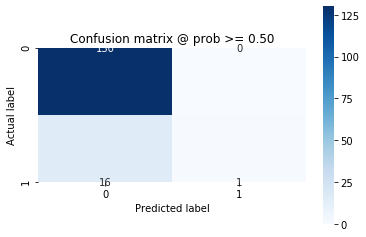

In [30]:
plt.figure(figsize=(7, 7))
plot_roc("Log Train", train_labels, model_logistic.decision_function(train_features), lcolor=colors[0], lwidth=1)
plot_roc("Log Test", test_labels, model_logistic.decision_function(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[1], lwidth=1)
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("SVC Train", train_labels, model_SVC.decision_function(train_features), lcolor=colors[2], lwidth=1)
plot_roc("SVC Test", test_labels, model_SVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("RadiusNC Train", train_labels, model_RadiusNC.predict(train_features), lcolor=colors[3])
plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), lcolor=colors[3], lstyle='--')
plt.legend(loc='lower right')
plt.show()

plot_cm(test_labels, model_RadiusNC.predict(test_features))

## 5. Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier as RForest

In [32]:
m_RF = RForest(criterion='gini',
               max_features='auto',
               class_weight=class_weights,
               n_jobs=6,
               random_state=0)

parameters = [{'n_estimators' : [i for i in range(600,800,100)],
               'max_depth' : [i for i in range(10,20,3)],
               'min_samples_split' : [i for i in range (2,4)], 
               'min_samples_leaf' : [i for i in range (2,4)],
               'warm_start' : [True, False]}]

grid_s = sklearn.model_selection.GridSearchCV(m_RF, parameters, cv=10, refit=True, n_jobs=6, verbose=2)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_RandomForest = grid_s.best_estimator_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   29.6s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 640 out of 640 | elapsed:  2.2min finished


RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.5991943605236657,
                                     1: 3.0203045685279184},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=600, n_jobs=6, oob_score=False,
                       random_state=0, verbose=0, warm_start=True)


In [33]:
models_summary = save_metrics(models_summary, model_RandomForest, test_labels, model_RandomForest.predict_proba(test_features)[:, 1]>0.5)
models_summary.sort_values(by=['f1', 'auc', 'prec'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
1,"LinearSVC(C=3, class_weight={0: 0.599194360523...",10,5,125,7,0.918367,0.666667,0.588235,0.774887,0.625000,0.580828,NaN
0,"LogisticRegression(C=1,\n cl...",13,15,115,4,0.870748,0.464286,0.764706,0.824661,0.577778,0.528814,NaN
4,"(DecisionTreeClassifier(class_weight=None, cri...",8,4,126,9,0.911565,0.666667,0.470588,0.719910,0.551724,0.513704,NaN
3,"RadiusNeighborsClassifier(algorithm='auto', le...",1,0,130,16,0.891156,1.000000,0.058824,0.529412,0.111111,0.228860,NaN
2,"SVC(C=3, cache_size=200,\n class_weight={0:...",0,0,130,17,0.884354,0.000000,0.000000,0.500000,0.000000,0.000000,NaN


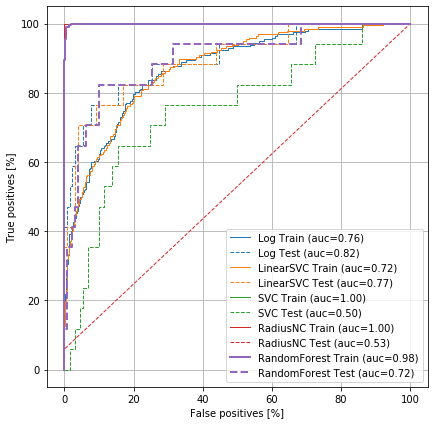

Stayers Detected (True Negatives):  126
Leavers Incorrectly Detected (False Positives):  4
Stayers Incorrectly Detected (False Negatives):  9
Leavers Detected (True Positives):  8


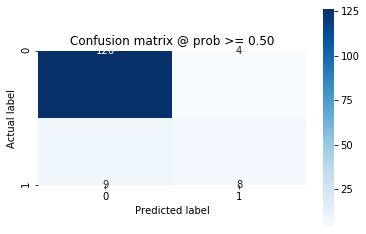

In [34]:
plt.figure(figsize=(7, 7))
plot_roc("Log Train", train_labels, model_logistic.decision_function(train_features), lcolor=colors[0], lwidth=1)
plot_roc("Log Test", test_labels, model_logistic.decision_function(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[1], lwidth=1)
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("SVC Train", train_labels, model_SVC.decision_function(train_features), lcolor=colors[2], lwidth=1)
plot_roc("SVC Test", test_labels, model_SVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("RadiusNC Train", train_labels, model_RadiusNC.predict(train_features), lcolor=colors[3], lwidth=1)
plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), lcolor=colors[3], lstyle='--', lwidth=1)

plot_roc("RandomForest Train", train_labels, model_RandomForest.predict_proba(train_features)[:, 1], lcolor=colors[4])
plot_roc("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], lcolor=colors[4], lstyle='--')
plt.legend(loc='lower right')
plt.show()

plot_cm(test_labels, model_RandomForest.predict(test_features))

## 5. Keras Tensorflow Classification NN

In [35]:
import tensorflow as tf
from tensorflow import keras

In [36]:
METRICS = [
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'), 
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
]


def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(train_features.shape[-1]+1, activation='relu', input_shape=(train_features.shape[-1],)), #best 30
      keras.layers.Dropout(0.1),
      keras.layers.Dense(24, activation='relu'), #best 24
      #keras.layers.Dropout(0.05),
      #keras.layers.Dense(12, activation='relu'), #best 12
      #keras.layers.Dropout(0.5),
      #keras.layers.Dense(5, activation='relu'), #best 5
      #keras.layers.Dropout(0.1),
      keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias), # sigmoid for regressor with probability output
  ])

    # Designing NN:
    # https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    
  model.compile(
      optimizer=keras.optimizers.Adam(lr=0.001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [37]:
EPOCHS = 100
BATCH_SIZE = 64
#best batch size = 64, 70, 32, 128, 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=20, #best 20
    restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=10,
    cooldown=5,
    min_lr=0.00001)

In [38]:
model_keras = make_model()
model_keras.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 46)                2116      
_________________________________________________________________
dropout (Dropout)            (None, 46)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 3,269
Trainable params: 3,269
Non-trainable params: 0
_________________________________________________________________


In [39]:
#Loss with correct initialization of bias
initial_bias = np.log([pos/neg])
model_keras = make_model(output_bias = initial_bias)

results = model_keras.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4529


In [40]:
#saving correct bias
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model_keras.save_weights(initial_weights)

In [41]:
model_keras = make_model()
model_keras.load_weights(initial_weights)
baseline_history = model_keras.fit(train_features,
                                    train_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    callbacks = [early_stopping, reduce_lr],
                                    validation_data=(val_features, val_labels))

Train on 1190 samples, validate on 133 samples
Epoch 1/100
1190/1190 [==============================] - 1s 822us/sample - loss: 0.4420 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 993.0000 - fn: 197.0000 - accuracy: 0.8345 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6002 - val_loss: 0.4522 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 110.0000 - val_fn: 23.0000 - val_accuracy: 0.8271 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6144
Epoch 2/100
1190/1190 [==============================] - 0s 52us/sample - loss: 0.4261 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 993.0000 - fn: 197.0000 - accuracy: 0.8345 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6931 - val_loss: 0.4392 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 110.0000 - val_fn: 23.0000 - val_accuracy: 0.8271 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6917
Epoch 3/100
1190/1190 [==============================] - 0s 55us/sample - loss: 0.4084 - tp: 0.0000e+00 - fp: 

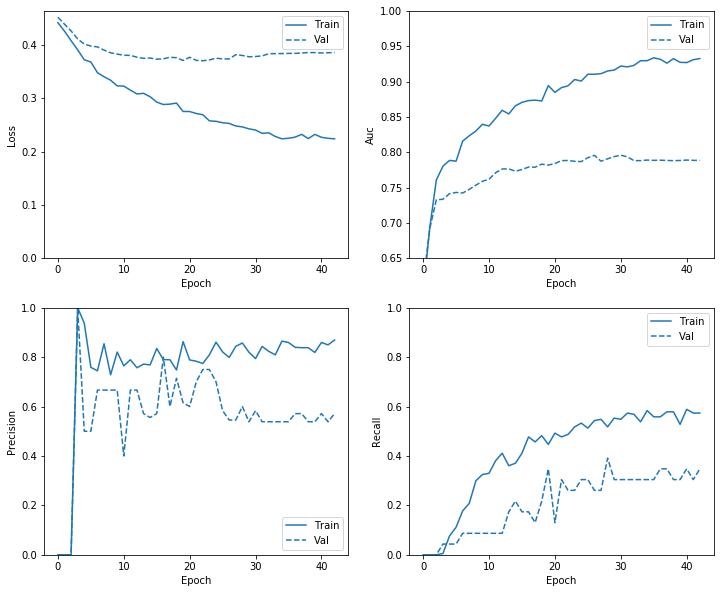

In [42]:
plot_nn_metrics(baseline_history)

In [43]:
train_predictions_baseline = model_keras.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model_keras.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.21889448961635835
tp :  11.0
fp :  5.0
tn :  125.0
fn :  6.0
accuracy :  0.92517006
precision :  0.6875
recall :  0.64705884
auc :  0.8864253

Stayers Detected (True Negatives):  125
Leavers Incorrectly Detected (False Positives):  5
Stayers Incorrectly Detected (False Negatives):  6
Leavers Detected (True Positives):  11


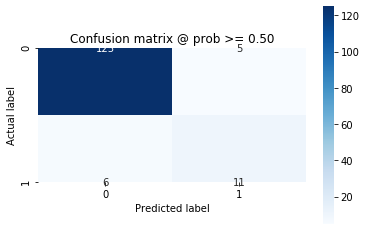

In [44]:
baseline_results = model_keras.evaluate(test_features, 
                                        test_labels,
                                        batch_size=BATCH_SIZE, 
                                        verbose=0)
for name, value in zip(model_keras.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [45]:
models_summary = save_metrics(models_summary, 'NN_base', test_labels, model_keras.predict(test_features), batch_size=BATCH_SIZE)
models_summary.sort_values(by=['f1', 'auc', 'prec'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
5,NN_base,11,5,125,6,0.925170,0.687500,0.647059,0.804299,0.666667,0.624929,64.0
1,"LinearSVC(C=3, class_weight={0: 0.599194360523...",10,5,125,7,0.918367,0.666667,0.588235,0.774887,0.625000,0.580828,NaN
0,"LogisticRegression(C=1,\n cl...",13,15,115,4,0.870748,0.464286,0.764706,0.824661,0.577778,0.528814,NaN
4,"(DecisionTreeClassifier(class_weight=None, cri...",8,4,126,9,0.911565,0.666667,0.470588,0.719910,0.551724,0.513704,NaN
3,"RadiusNeighborsClassifier(algorithm='auto', le...",1,0,130,16,0.891156,1.000000,0.058824,0.529412,0.111111,0.228860,NaN
2,"SVC(C=3, cache_size=200,\n class_weight={0:...",0,0,130,17,0.884354,0.000000,0.000000,0.500000,0.000000,0.000000,NaN


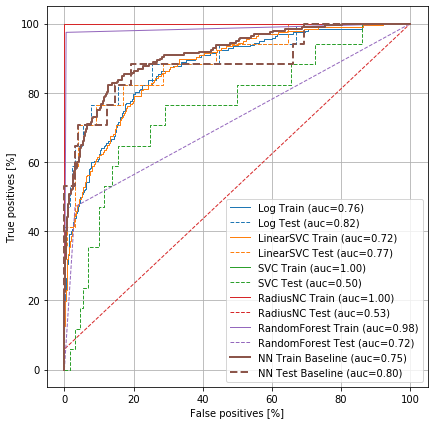

In [46]:
plt.figure(figsize=(7, 7))
plot_roc("Log Train", train_labels, model_logistic.decision_function(train_features), lcolor=colors[0], lwidth=1)
plot_roc("Log Test", test_labels, model_logistic.decision_function(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[1], lwidth=1)
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("SVC Train", train_labels, model_SVC.decision_function(train_features), lcolor=colors[2], lwidth=1)
plot_roc("SVC Test", test_labels, model_SVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("RadiusNC Train", train_labels, model_RadiusNC.predict(train_features), lcolor=colors[3], lwidth=1)
plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), lcolor=colors[3], lstyle='--', lwidth=1)

plot_roc("RandomForest Train", train_labels, model_RandomForest.predict(train_features), lcolor=colors[4], lwidth=1)
plot_roc("RandomForest Test", test_labels, model_RandomForest.predict(test_features), lcolor=colors[4], lstyle='--', lwidth=1)

plot_roc("NN Train Baseline", train_labels, train_predictions_baseline, lcolor=colors[5])
plot_roc("NN Test Baseline", test_labels, test_predictions_baseline, lcolor=colors[5], lstyle='--')
plt.legend(loc='lower right')
plt.show()

In [47]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping, reduce_lr],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weights) 

Train on 1190 samples, validate on 133 samples
Epoch 1/100
1190/1190 [==============================] - 1s 1ms/sample - loss: 0.9427 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 993.0000 - fn: 197.0000 - accuracy: 0.8345 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5264 - val_loss: 0.5031 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 110.0000 - val_fn: 23.0000 - val_accuracy: 0.8271 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4982
Epoch 2/100
1190/1190 [==============================] - 0s 73us/sample - loss: 0.7065 - tp: 35.0000 - fp: 91.0000 - tn: 902.0000 - fn: 162.0000 - accuracy: 0.7874 - precision: 0.2778 - recall: 0.1777 - auc: 0.5825 - val_loss: 0.6722 - val_tp: 10.0000 - val_fp: 44.0000 - val_tn: 66.0000 - val_fn: 13.0000 - val_accuracy: 0.5714 - val_precision: 0.1852 - val_recall: 0.4348 - val_auc: 0.5451
Epoch 3/100
1190/1190 [==============================] - 0s 67us/sample - loss: 0.6741 - tp: 124.0000 - fp: 468.0000 - tn: 525.0000 - fn: 73.

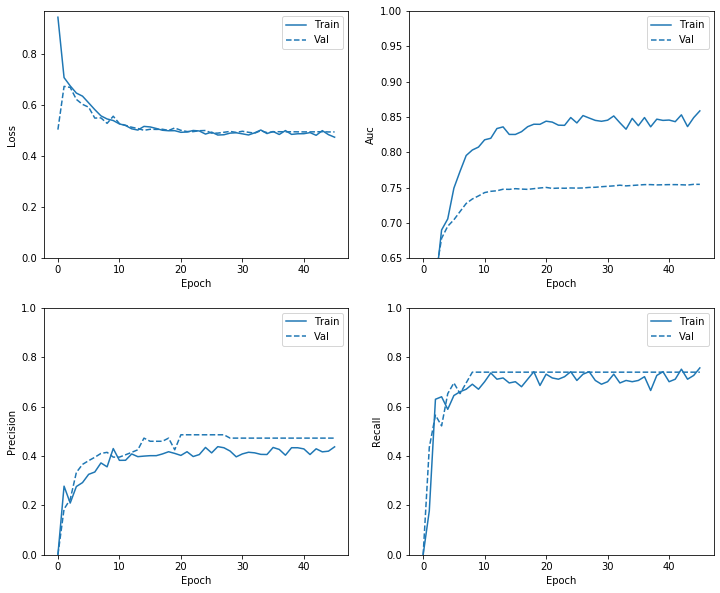

In [48]:
plot_nn_metrics(weighted_history)

In [49]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.4392061837676431
tp :  15.0
fp :  22.0
tn :  108.0
fn :  2.0
accuracy :  0.8367347
precision :  0.4054054
recall :  0.88235295
auc :  0.88755655

Stayers Detected (True Negatives):  108
Leavers Incorrectly Detected (False Positives):  22
Stayers Incorrectly Detected (False Negatives):  2
Leavers Detected (True Positives):  15


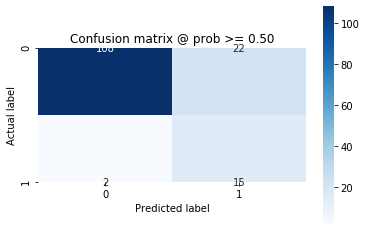

In [50]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

In [51]:
models_summary = save_metrics(models_summary, 'NN_weighted', test_labels, weighted_model.predict(test_features, batch_size=BATCH_SIZE), batch_size=BATCH_SIZE)
models_summary.sort_values(by=['f1', 'auc', 'prec'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
5,NN_base,11,5,125,6,0.925170,0.687500,0.647059,0.804299,0.666667,0.624929,64.0
1,"LinearSVC(C=3, class_weight={0: 0.599194360523...",10,5,125,7,0.918367,0.666667,0.588235,0.774887,0.625000,0.580828,NaN
0,"LogisticRegression(C=1,\n cl...",13,15,115,4,0.870748,0.464286,0.764706,0.824661,0.577778,0.528814,NaN
6,NN_weighted,15,22,108,2,0.836735,0.405405,0.882353,0.856561,0.555556,0.525488,64.0
4,"(DecisionTreeClassifier(class_weight=None, cri...",8,4,126,9,0.911565,0.666667,0.470588,0.719910,0.551724,0.513704,NaN
3,"RadiusNeighborsClassifier(algorithm='auto', le...",1,0,130,16,0.891156,1.000000,0.058824,0.529412,0.111111,0.228860,NaN
2,"SVC(C=3, cache_size=200,\n class_weight={0:...",0,0,130,17,0.884354,0.000000,0.000000,0.500000,0.000000,0.000000,NaN


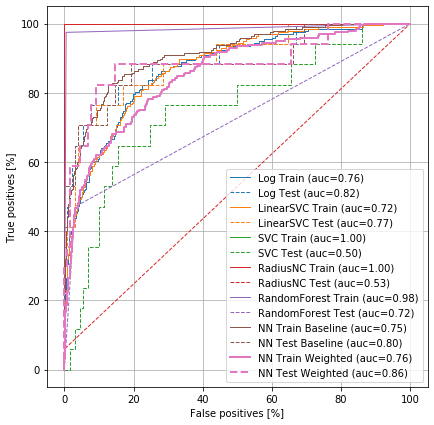

In [52]:
plt.figure(figsize=(7, 7))
plot_roc("Log Train", train_labels, model_logistic.decision_function(train_features), lcolor=colors[0], lwidth=1)
plot_roc("Log Test", test_labels, model_logistic.decision_function(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[1], lwidth=1)
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("SVC Train", train_labels, model_SVC.decision_function(train_features), lcolor=colors[2], lwidth=1)
plot_roc("SVC Test", test_labels, model_SVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("RadiusNC Train", train_labels, model_RadiusNC.predict(train_features), lcolor=colors[3], lwidth=1)
plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), lcolor=colors[3], lstyle='--', lwidth=1)

plot_roc("RandomForest Train", train_labels, model_RandomForest.predict(train_features), lcolor=colors[4], lwidth=1)
plot_roc("RandomForest Test", test_labels, model_RandomForest.predict(test_features), lcolor=colors[4], lstyle='--', lwidth=1)

plot_roc("NN Train Baseline", train_labels, train_predictions_baseline, lcolor=colors[5], lwidth=1)
plot_roc("NN Test Baseline", test_labels, test_predictions_baseline, lcolor=colors[5], lstyle='--', lwidth=1)

plot_roc("NN Train Weighted", train_labels, train_predictions_weighted, lcolor=colors[6])
plot_roc("NN Test Weighted", test_labels, test_predictions_weighted, lcolor=colors[6], lstyle='--')

plt.legend(loc='lower right')
plt.show()

In [53]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [54]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(993, 45)

In [55]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(1986, 45)

In [56]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [57]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

32.0

In [58]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping, reduce_lr],
    validation_data=val_ds)

Epoch 1/100
32/32 [==============================] - 1s 39ms/step - loss: 0.8245 - tp: 49.0000 - fp: 34.0000 - tn: 1034.0000 - fn: 931.0000 - accuracy: 0.5288 - precision: 0.5904 - recall: 0.0500 - auc: 0.5111 - val_loss: 0.6315 - val_tp: 6.0000 - val_fp: 28.0000 - val_tn: 82.0000 - val_fn: 17.0000 - val_accuracy: 0.6617 - val_precision: 0.1765 - val_recall: 0.2609 - val_auc: 0.5249
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6615 - tp: 642.0000 - fp: 419.0000 - tn: 601.0000 - fn: 386.0000 - accuracy: 0.6069 - precision: 0.6051 - recall: 0.6245 - auc: 0.6459 - val_loss: 0.6067 - val_tp: 12.0000 - val_fp: 27.0000 - val_tn: 83.0000 - val_fn: 11.0000 - val_accuracy: 0.7143 - val_precision: 0.3077 - val_recall: 0.5217 - val_auc: 0.6694
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6088 - tp: 622.0000 - fp: 259.0000 - tn: 782.0000 - fn: 385.0000 - accuracy: 0.6855 - precision: 0.7060 - recall: 0.6177 - auc: 0.7448 - val_loss: 0.576

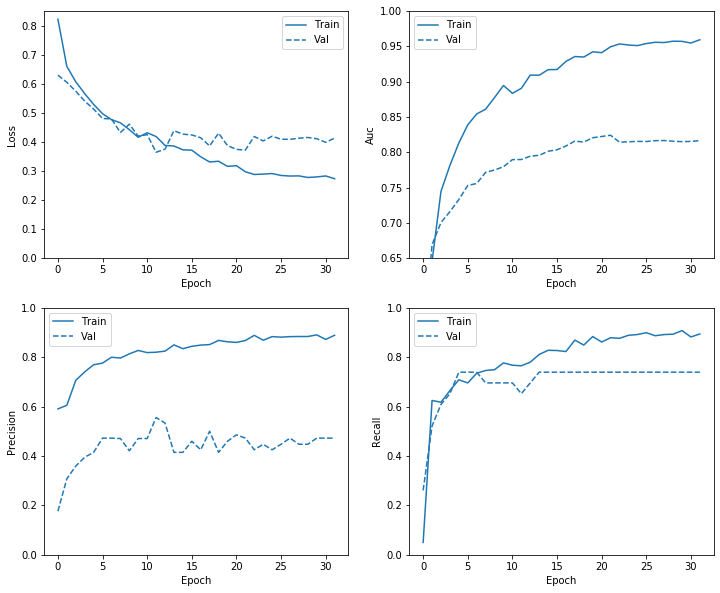

In [59]:
plot_nn_metrics(resampled_history)

In [60]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.3244569693901101
tp :  12.0
fp :  15.0
tn :  115.0
fn :  5.0
accuracy :  0.8639456
precision :  0.44444445
recall :  0.7058824
auc :  0.89343894

Stayers Detected (True Negatives):  108
Leavers Incorrectly Detected (False Positives):  22
Stayers Incorrectly Detected (False Negatives):  2
Leavers Detected (True Positives):  15


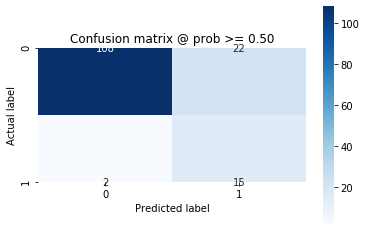

In [61]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

In [62]:
models_summary = save_metrics(models_summary, 'NN_resampled', test_labels, resampled_model.predict(test_features, batch_size=BATCH_SIZE), batch_size=BATCH_SIZE)

In [63]:
models_summary[models_summary.prec > 0.4].sort_values(by=['f1','auc','mc_coef'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
5,NN_base,11,5,125,6,0.925170,0.687500,0.647059,0.804299,0.666667,0.624929,64.0
1,"LinearSVC(C=3, class_weight={0: 0.599194360523...",10,5,125,7,0.918367,0.666667,0.588235,0.774887,0.625000,0.580828,NaN
0,"LogisticRegression(C=1,\n cl...",13,15,115,4,0.870748,0.464286,0.764706,0.824661,0.577778,0.528814,NaN
6,NN_weighted,15,22,108,2,0.836735,0.405405,0.882353,0.856561,0.555556,0.525488,64.0
4,"(DecisionTreeClassifier(class_weight=None, cri...",8,4,126,9,0.911565,0.666667,0.470588,0.719910,0.551724,0.513704,NaN
7,NN_resampled,12,15,115,5,0.863946,0.444444,0.705882,0.795249,0.545455,0.487688,64.0
3,"RadiusNeighborsClassifier(algorithm='auto', le...",1,0,130,16,0.891156,1.000000,0.058824,0.529412,0.111111,0.228860,NaN


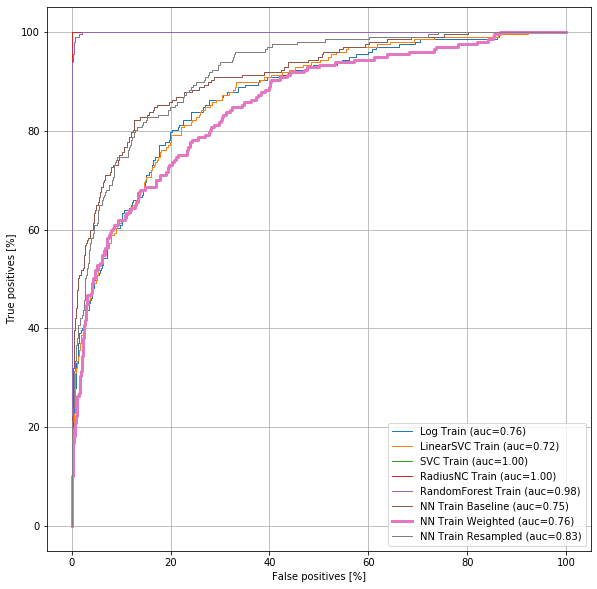

In [64]:
fig = plt.figure(figsize=(10,10))
plot_roc("Log Train", train_labels, model_logistic.decision_function(train_features), lcolor=colors[0], lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[1], lwidth=1)

plot_roc("SVC Train", train_labels, model_SVC.decision_function(train_features), lcolor=colors[2], lwidth=1)

plot_roc("RadiusNC Train", train_labels, model_RadiusNC.predict(train_features), lcolor=colors[3], lwidth=1)

plot_roc("RandomForest Train", train_labels, model_RandomForest.predict_proba(train_features)[:, 1], lcolor=colors[4], lwidth=1)

plot_roc("NN Train Baseline", train_labels, train_predictions_baseline, lcolor=colors[5], lwidth=1)

plot_roc("NN Train Weighted", train_labels, train_predictions_weighted, lcolor=colors[6], lwidth=3)

plot_roc("NN Train Resampled", train_labels, train_predictions_resampled,  lcolor=colors[7], lwidth=1)
plt.legend(loc='lower right')
plt.show()

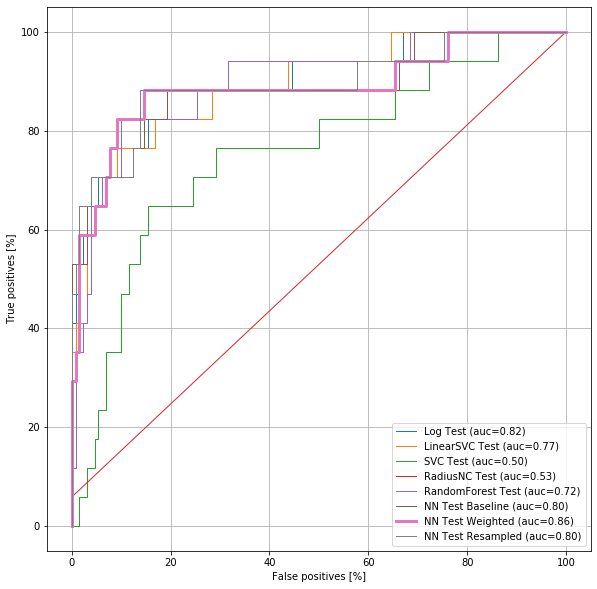

In [65]:
fig = plt.figure(figsize=(10,10))
plot_roc("Log Test", test_labels, model_logistic.decision_function(test_features), lcolor=colors[0], lstyle='-', lwidth=1)

plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[1], lstyle='-', lwidth=1)

plot_roc("SVC Test", test_labels, model_SVC.decision_function(test_features), lcolor=colors[2], lstyle='-', lwidth=1)

plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), lcolor=colors[3], lstyle='-', lwidth=1)

plot_roc("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], lcolor=colors[4], lstyle='-', lwidth=1)

plot_roc("NN Test Baseline", test_labels, test_predictions_baseline, lcolor=colors[5], lstyle='-', lwidth=1)

plot_roc("NN Test Weighted", test_labels, test_predictions_weighted, lcolor=colors[6], lstyle='-', lwidth=3)

plot_roc("NN Test Resampled", test_labels, test_predictions_resampled,  lcolor=colors[7], lstyle='-', lwidth=1)
plt.legend(loc='lower right')
plt.show()

# Further model exploration

## A. Recursive Feature Selection with Stratified Kfold CV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Optimal number of features : 23


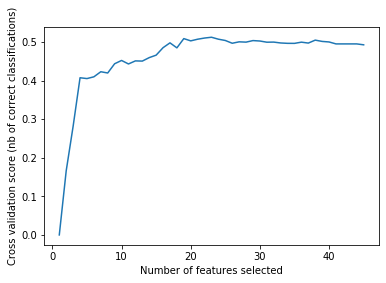

In [96]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Logistic Model
rfecv = RFECV(estimator=model_logistic, step=1, cv=StratifiedKFold(3, shuffle=True, random_state=0),
              scoring='f1')
rfecv.fit(finaldf.drop(['Attrition_Yes'], axis=1), finaldf.Attrition_Yes)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Optimal number of features : 32


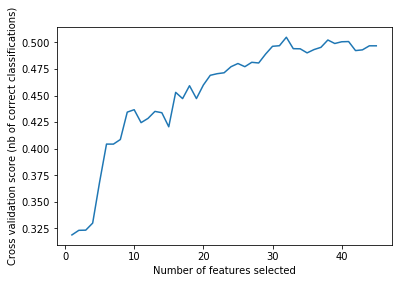

In [97]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# LinearSVC Model
rfecv = RFECV(estimator=model_LinearSVC, step=1, cv=StratifiedKFold(3, shuffle=True, random_state=0),
              scoring='f1')
rfecv.fit(finaldf.drop(['Attrition_Yes'], axis=1), finaldf.Attrition_Yes)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## B. Stratified Kfold CV on models and summary

# Conclusion

In [73]:
models_summary[models_summary.prec > 0.4].sort_values(by=['f1','auc','mc_coef'], ascending=False).head(3)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
5,NN_base,11,5,125,6,0.925170,0.687500,0.647059,0.804299,0.666667,0.624929,64.0
1,"LinearSVC(C=3, class_weight={0: 0.599194360523...",10,5,125,7,0.918367,0.666667,0.588235,0.774887,0.625000,0.580828,NaN
0,"LogisticRegression(C=1,\n cl...",13,15,115,4,0.870748,0.464286,0.764706,0.824661,0.577778,0.528814,NaN


In [81]:
from scipy import stats
params = np.append(model_logistic.intercept_,model_logistic.coef_)
predictions = model_logistic.predict(test_features)

newX = pd.DataFrame({"Constant":np.ones(len(test_features))}).join(pd.DataFrame(test_features))
MSE = (sum((test_labels-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["features"],myDF3["coef"],myDF3["se"],myDF3["t_values"],myDF3["p_value"] = [['']+test_df.columns.to_list(), params,sd_b,ts_b,p_values]
myDF3[myDF3['p_value'] < 0.05].sort_values(by=['coef'], ascending=False)

,features,coef,se,t_values,p_value
23,YearsSinceLastPromotion,1.9848,0.334,5.936,0.000
45,OverTime_Yes,1.7025,0.139,12.243,0.000
36,JobRole_LaboratoryTechnician,1.3104,0.271,4.838,0.000
42,JobRole_SalesRepresentative,1.2935,0.516,2.509,0.013
44,MaritalStatus_Single,1.1390,0.231,4.940,0.000
13,NumCompaniesWorked,1.1005,0.231,4.754,0.000
3,DistanceFromHome,0.9919,0.182,5.458,0.000
43,MaritalStatus_Married,0.4681,0.179,2.617,0.010
34,Gender_Male,0.3383,0.112,3.012,0.003
16,RelationshipSatisfaction,-0.5368,0.161,-3.339,0.001


In [82]:
myDF3[myDF3['p_value'] > 0.05].sort_values(by=['coef'], ascending=False)

,features,coef,se,t_values,p_value
0,,1.5549,8331310.270,0.000,1.000
35,JobRole_HumanResources,1.4761,8331310.270,0.000,1.000
21,YearsAtCompany,1.3916,0.918,1.516,0.132
28,Department_Sales,0.7445,8331310.270,0.000,1.000
33,EducationField_TechnicalDegree,0.7349,0.750,0.980,0.329
40,JobRole_ResearchScientist,0.5170,0.263,1.968,0.051
41,JobRole_SalesExecutive,0.3678,0.456,0.807,0.421
15,PerformanceRating,0.2813,0.240,1.174,0.242
27,Department_ResearchDevelopment,0.2607,8331310.270,0.000,1.000
12,MonthlyRate,0.1482,0.193,0.767,0.444


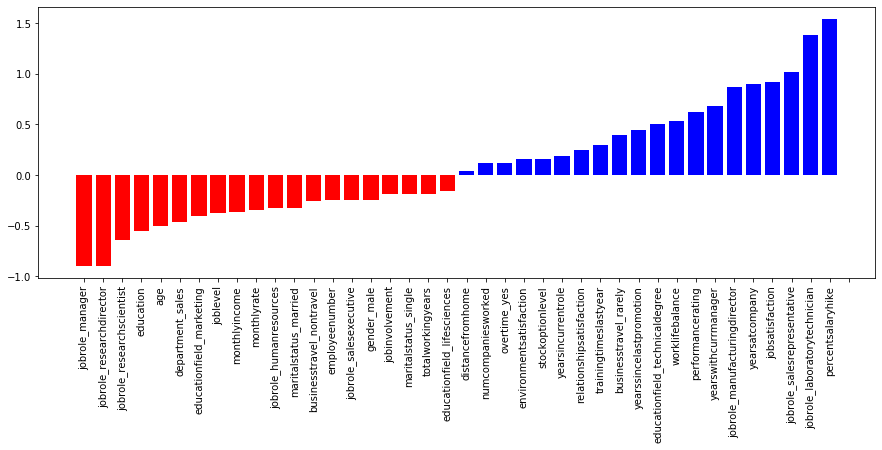

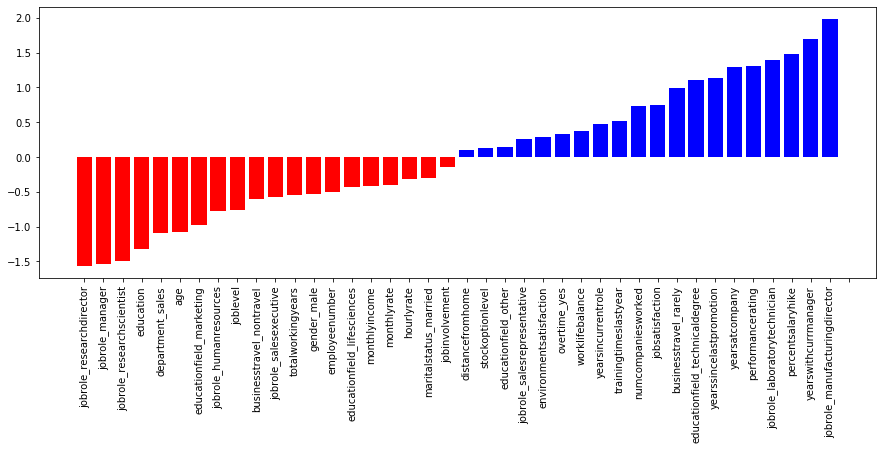

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=90, ha='center')
 plt.show()

cv = CountVectorizer()
cv.fit(test_df)

plot_coefficients(model_LinearSVC, cv.get_feature_names())
plot_coefficients(model_logistic, cv.get_feature_names())